In [671]:
import numpy as np
import matplotlib.pyplot as plt
from htmresearch.support.gridcells.context_integration.context_layer import ContextLayer
from scipy.stats import entropy
%matplotlib inline
%load_ext autoreload
%autoreload 2

def encode(digit, n, w=4):
    start = digit * n/10
    end = start + w
    return [ i%n for i in range(start, end)]


n = 50
d = 10
m = (n**2)//d


print n**2, m*d
print m

# 
# n = 30, d = 10
# can store 54 patterns with w=1
# 


a = np.array([1,0])
b = np.array([0,1])


action_matrix = np.array([
    [1,0],
    [0,1]
])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2500 2500
250


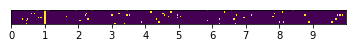

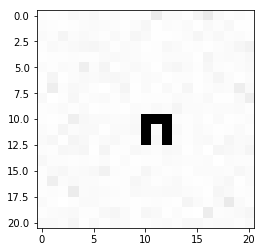

In [672]:

w = 1


CL = ContextLayer(layer_shape=(d,m), module_shape=(n,n),action_map = action_matrix) 

FEATURE = np.zeros((10,d,m))
for i in range(10):
    FEATURE[i,:,encode(i%10,m,w)] = 1

    
CL.add(FEATURE[1])
CL.extend(a, FEATURE[2])
CL.extend(a, FEATURE[3])
CL.extend(-2*a + b, FEATURE[4])
# CL.extend(a, FEATURE[5])
CL.explore(a)
# CL.extend(a, FEATURE[6])
CL.explore(a)
CL.extend(-2*a + b, FEATURE[7])
CL.extend(a, FEATURE[8])
CL.extend(a, FEATURE[9])



CL.explore(-2*a -2*b)

plt.imshow(CL.layer)
plt.xticks([i * m/10 for i in range(10)], range(10))
plt.yticks([])
plt.show()


fmap = CL.decode_bw(10)
plt.imshow(fmap, cmap="binary")


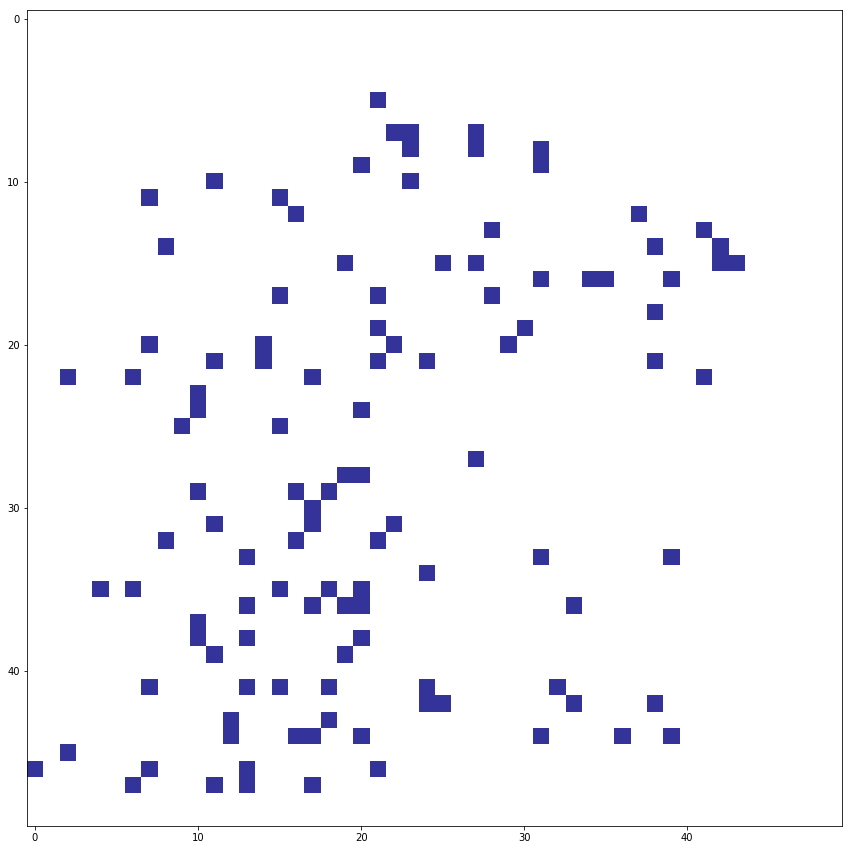

In [537]:
"""Create an environment."""

num_features = 2
num_components = 25
num_components_in_env = 40

env = np.zeros((50,50))
colors = [0,1,2,3,4,5,6]


features = np.arange(num_features)
p_blank  = 0.99
prob_f   = [ p_blank] + [(1-p_blank)/(len(features)-1)]*(len(features)-1)
component_shapes = [
    (5,5),
    (15,15),
    (44,30),    
    (20,10),
    (19,33)
]

components = []
for i in range(num_components):
    i_shape = np.random.choice(len(component_shapes))
    shape   = component_shapes[i_shape]
    component = np.random.choice(features, size=shape, replace=True, p=prob_f)
    components.append(component)
#     component += np.random.sample()*0.1
    
for i in range(num_components_in_env):
    i_comp = np.random.choice(len(components))
    component = components[i_comp]
    shape   = component.shape

    x0 = np.random.randint(env.shape[0] - shape[0])
    x1 = np.random.randint(env.shape[1] - shape[1])
    
    mask = np.where(component != 0)
    env[x0:(x0+shape[0]), x1:(x1+shape[1])][mask] = component[mask]
    
plt.figure(figsize=(15,15))
plt.imshow(-env, cmap="terrain")


# for f in range(num_features):
#     xs = np.where(env==f)[0], 
#     ys = np.where(env==f)[1]
#     plt.scatter(xs,ys, s=10, marker="s",  edgecolor='red',  lw = 0)

# plt.scatter([],[50], s=200, marker="^", c="red", edgecolor='red',  lw = 1)










(100000, 2)
0.999995649945 1.88139325877e-06


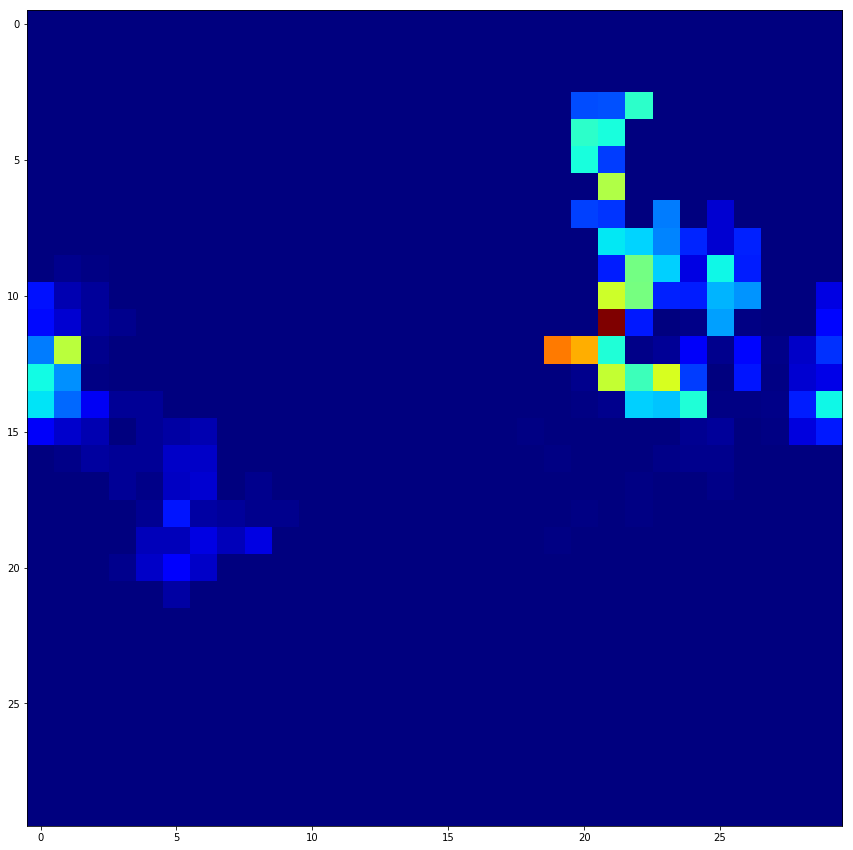

In [673]:
from htmresearch.support.gridcells.random_walk import smooth_torus_walk


env = (np.random.sample((30,30)) > 0.85).astype(float)

num_steps = 100000
X, _ = smooth_torus_walk(num_steps, start=[0.5,0.5], min_speed=0.03, max_speed=0.05, sigma=12.5)
print X.shape
print np.amax(X), np.amin(X)

X[:,0] *= (env.shape[0] )
X[:,1] *= (env.shape[1] )
X = X.astype(int)
heatmap_agent = np.zeros(env.shape)
V = np.zeros(X.shape)
for t in range( X.shape[0] - 1):
    V[t,:] = X[t+1] - X[t] 
    
for x in X:
    heatmap_agent *= 0.99
    heatmap_agent[x[0],x[1]] += 0.1

plt.figure(figsize=(15,15))
plt.imshow(heatmap_agent, cmap="jet")


done


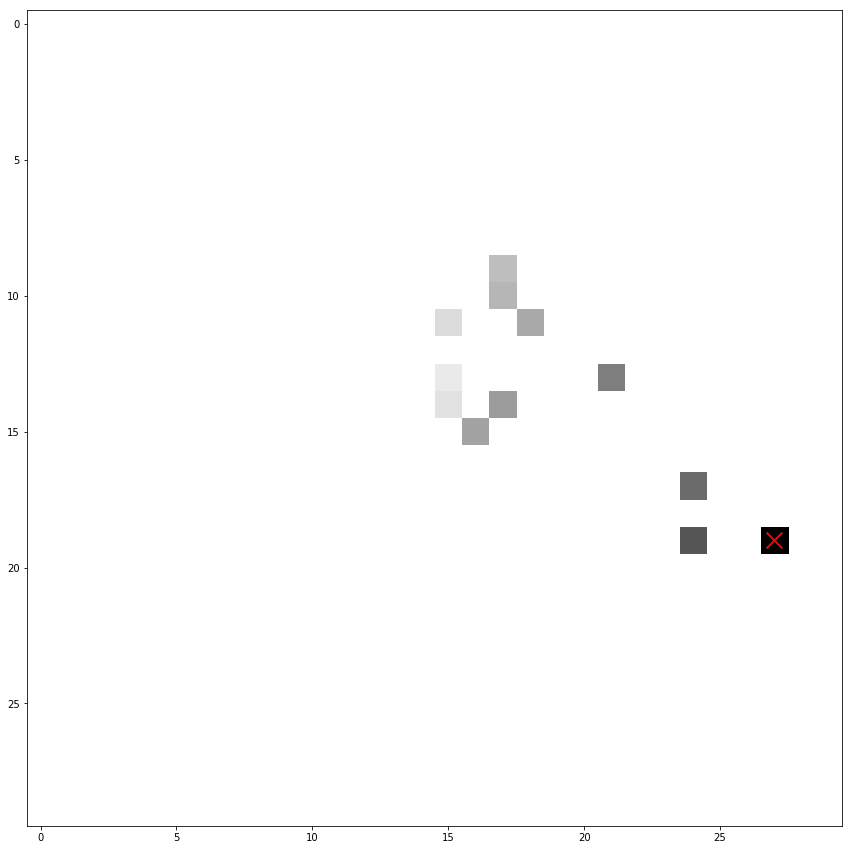

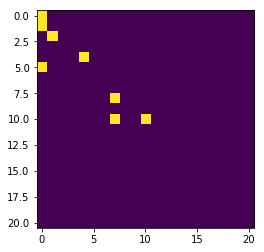

(30, 30)


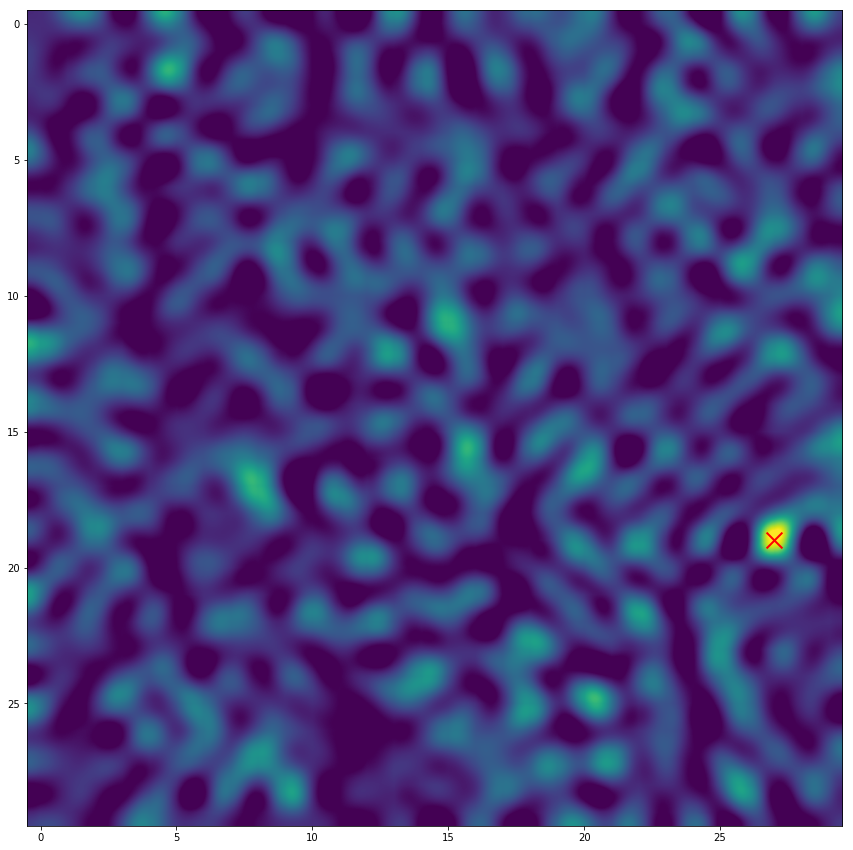

In [703]:
w = 1

env = (np.random.sample((30,30)) > 0.85).astype(float)
CL = ContextLayer(layer_shape=(d,m), module_shape=(n,n), action_map = action_matrix, max_activity=150) 


def create_movie(imgs, filename, title, fps=15, dpi=100):
    """Helps us to create a movie."""
    FFMpegWriter = manimation.writers['html']
    metadata = dict(title='Movie Test', artist='Matplotlib',
                comment='Movie support!')
    metadata     = dict(title=title)
    writer       = FFMpegWriter(fps=fps, metadata=metadata)
    fig = plt.figure()
    
    with writer.saving(fig, filename, dpi):
        for t in range(len(imgs)):
            plt.imshow(imgs[t])
            writer.grab_frame()


mask = np.zeros((21,21))
env_tensor = np.zeros((21,21, env.shape[0],env.shape[1]))
for x in range(env.shape[0]):
        for y in range(env.shape[1]):
            xs = [  k%env.shape[0] for k in range(x - mask.shape[0]//2 ,x + mask.shape[0]//2 + 1 )]
            ys = [  k%env.shape[1] for k in range(y - mask.shape[1]//2 ,y + mask.shape[1]//2 +1 ) ] 
            env_snip = env[xs,:][:,ys]
            env_tensor[:,:,x,y] = env_snip[:,:]


def position_estimate(CL, env_tensor):
    heat = np.zeros(env.shape)

    mask = CL.decode_bw(10)
    mask = mask - np.amin(mask)
    if np.amax(mask) > 0:
        mask = mask/np.amax(mask)
    mask = (mask > 0.8).astype(float)
    
    mask = mask.reshape((21,21,1,1))
#     mask = np.expand_dims(mask, axis=2)
#     mask = np.expand_dims(mask, axis=3)
    heat = np.sum(env_tensor*mask, axis=(0,1))
    print heat.shape
    
#     for x in range(env.shape[0]):
#         for y in range(env.shape[1]):
#             heat[x,y] = np.sum(env_tensor[:,:, x,y]*mask)

    # prob = np.exp(heat)
    prob = heat
    prob = prob/np.sum(prob)
    return prob
    
    
    



# T = X.shape[0]
T = 50
heatmap_agent = np.zeros(env.shape)
    
movie_frames = []
    
for t in range(0,150):
    CL.explore(V[t].astype(int))
    
    pos = X[t+1] 
    
    heatmap_agent *= 0.99
    heatmap_agent[pos[0],pos[1]] = 1
    
    f_id = int(env[pos[0],pos[1]] )
    if f_id > 0:
        CL.extend([0,0], FEATURE[ f_id ])
        


print "done"

# 

plt.figure(figsize=(15,15))
plt.imshow(- env + 6*(env * heatmap_agent), cmap="binary", vmin=0, vmax=5)
# plt.imshow( heatmap_agent.T , cmap="binary")

plt.scatter(X[t+1,1],X[t+1,0], s=250, marker="x", c="red", edgecolor='red',  lw = 2)

plt.show()


# mask = (CL.decode_bw(10) > 0.1).astype(float)
mask = CL.decode_bw(10)
mask = mask - np.amin(mask)
if np.amax(mask) > 0:
    mask = mask/np.amax(mask)
mask = (mask > 0.8).astype(float)
plt.imshow(mask)
plt.show()


# # heat = np.zeros((env.shape[0] - mask.shape[0], env.shape[1] - mask.shape[1]))
# heat = np.zeros(env.shape)


# for x in range(env.shape[0]):
#     for y in range(env.shape[1]):
#         xs = [  k%env.shape[0] for k in range(x - mask.shape[0]//2 ,x + mask.shape[0]//2 + 1 )]
#         ys = [  k%env.shape[1] for k in range(y - mask.shape[1]//2 ,y + mask.shape[1]//2 +1 ) ] 
#         env_snip = env[xs,:][:,ys]
#         heat[x  ,y  ] = np.sum( env_snip * mask )
        
# # prob = np.exp(heat)
# prob = heat
# prob = prob/np.sum(prob)

prob = position_estimate(CL, env_tensor)

plt.figure(figsize=(15,15))
# plt.imshow(prob, cmap="jet", interpolation='none')
plt.imshow(prob, cmap='viridis', interpolation='sinc')
plt.scatter(X[t+1,1],X[t+1,0], s=250, marker="x", c="red", edgecolor='red',  lw = 2)

# am = np.argmax(prob.reshape(-1))
# plt.scatter( am%env.shape[0], am//env.shape[0], s=250, marker="x", c="red", edgecolor='red',  lw = 2)
# plt.imshow(prob, cmap="jet", interpolation='gaussian')

# create_movie(movie_frames, "test.html", "ttt")


6.49185309633
6.49185309633
